<a target="_blank" href="https://colab.research.google.com/github/heechul/EmbeddedML/blob/main/l5-vww/train.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

# Mask-Detection using Transfer Learning
In this assignment you will use transfer learning to detect if the person is wearing a mask or not. We will use a pre-trained model (MobileNet-V2) trained on the ImageNet dataset and use a modified version of [kaggle mask dataset](https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset) to preform transfer learning.

Remember, a pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this assignment, you will customize a pretrained model in two ways:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.


You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model

**Acknowledgements**

This colab is heavily inspired from the [Google's Transfer learning](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb) Colab.


In [26]:
# Mask-detection assignment/module development
# Copyright (c) 2023 Heechul Yun
# Copyright (c) 2020 Srivatsan Krishnan
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [27]:
!pip install -U tf_keras  &> 0 # Keras 2
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [28]:
!pip install kagglehub
!pip install numpy
!pip install tensorflow
!pip install matplotlib
!pip install --upgrade --no-cache-dir gdown


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

RunningInCOLAB = 'google.colab' in str(get_ipython())

## Build the dataset

### Download the dataset
You will use a dataset containing several hundreds images of person with and without mask. First you will download and extract a zip file containing the images. Then  you will create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("constantinwerner/human-detection-dataset")
print("Path to dataset files:", path)

100%|██████████| 260M/260M [00:02<00:00, 98.1MB/s] 

Extracting files...


Path to dataset files: /home/heechul/.cache/kagglehub/datasets/constantinwerner/human-detection-dataset/versions/5


In [34]:
if RunningInCOLAB:
    !mv {path} /content/data
    !ls /content/data
    path = "/content/data"
else:
    !mv {path} data
    !ls data
    path = "./data"    
dataset_path = os.path.join(path, "human detection dataset")
print ("Path to dataset files:", dataset_path)

mv: cannot move './data' to a subdirectory of itself, 'data/data'


'human detection dataset'
Path to dataset files: ./data/human detection dataset


In [24]:
topdir = os.getcwd()
if not os.stat('model'):
    os.mkdir('model')
if not os.stat('src'):
    os.mkdir('src')
print(topdir)

/home/heechul/Teaching/EmbeddedML/l5-vww


In [35]:
import os
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (96, 96)
dataset = image_dataset_from_directory(dataset_path,
                                        labels='inferred',
                                        label_mode='binary',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

dataset_size = len(list(dataset))  # Get the total number of elements in the dataset
train_size = int(0.8 * dataset_size) # Calculate the size of the training set (80%)
val_size = int(0.2 * dataset_size) # Calculate the size of the validation set (20%)

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

Found 921 files belonging to 2 classes.


W0000 00:00:1731351700.057687 2606196 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-11 13:01:40.366407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:01:40.601308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:01:40.652669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:01:40.670766: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:01:40.800026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:01:40.845606: W tensorflow/core/lib/png

Now that we have built the dataset lets view the first nine images and labels from the training set:

['0', '1']


2024-11-11 13:03:30.938602: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:03:31.184227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:03:31.186416: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:03:31.234064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:03:31.319561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:03:31.355092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:03:31.513818: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


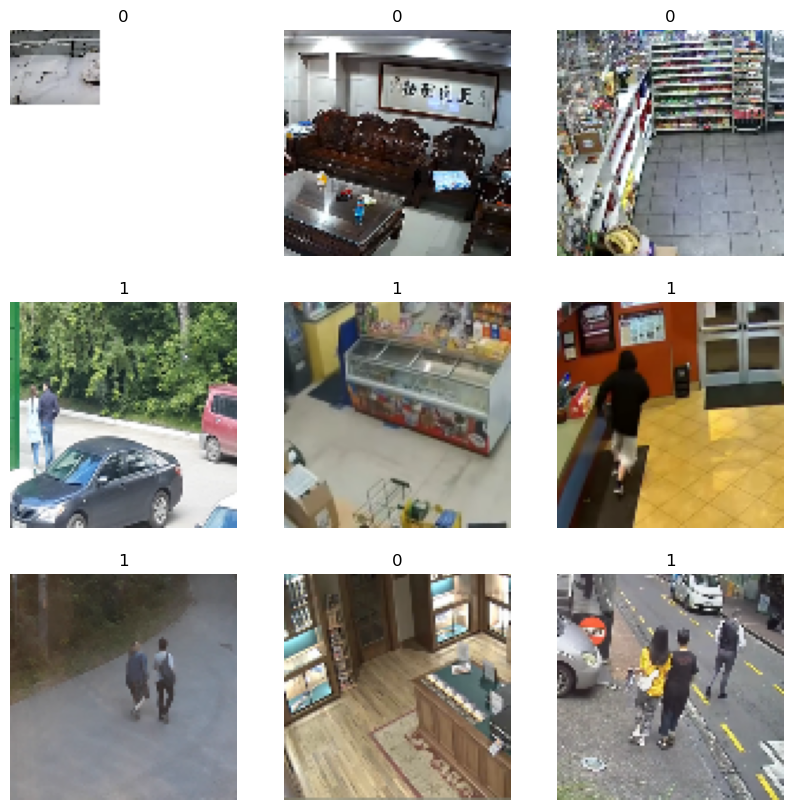

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

class_names = dataset.class_names
print (class_names)
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    idx = labels[i].numpy().astype("uint8")[0]
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[idx])
    plt.axis("off")

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [38]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

Note: If you go on to use other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Build the Model

### Create the base model
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories including objects such as `jackfruit` and `syringe`. This base of knowledge will help us classify if a person is wearing a mask or not from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will leverage as the high level features you wish to re-use. Since we want to adapt the classifications coming out of the model to a new task, we want to leverage the features coming out of the *last* layer BEFORE the classification layers. In many image models this is the output of the final convolution BEFORE the flatten layer. You may see this layer referred to as the "bottleneck layer" in some texts. Since many machine learning models are defined as the inputs occuring at the bottom and the outputs occuring at the top we would like to ignore the top few classification layers. Fortuntately, there is a shortcut to doing this in TensorFlow, **```include_top=False```**. By passing in this parameter we instantiate a MobileNet V1 model pre-loaded with weights trained on ImageNet that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [40]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               alpha=0.35,
                                               weights='imagenet')

2019640/2019640 [==============================] - 0s 0us/step


In [41]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-11-11 13:10:27.535809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:10:27.762992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:10:27.766360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:10:27.818013: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 13:10:27.942807: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


(32, 3, 3, 1280)


2024-11-11 13:10:27.983660: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


### Freeze the convolutional layers

It is important to freeze the convolutional layers before you compile and train the model with transfer learning. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. We want to perform this operation because we want to leverage the pre-trained values in the convolutional layers and only learn new classification layer values. We can do this by setting the entire model's `trainable` flag to False.

In [42]:
print (base_model.trainable)
base_model.trainable = False
print (base_model.trainable)


True
False


In [43]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 16)           432       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 16)           64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 16)           0         ['bn_Conv1[0

### Add a classification head

To begin the process of generating classifications from the pretrained features, we use a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the 3x3 spatial features into a single 1024-element feature vector per image.

In [44]:
classification_input_layer = tf.keras.layers.Flatten()
# classification_input_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = classification_input_layer(feature_batch)
print(feature_batch_average.shape)

(32, 11520)


We then apply a `tf.keras.layers.Dense` layer to convert the feature vector into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [45]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


We can then build our final model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). Importantly we remind Tensorflow that we do not want to train the base_model!

In [47]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = classification_input_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output. You can see below how we have included the Mobilenet V1 model after the input layer and before our classification layers!

In [48]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_0.35_96 (Funct  (None, 3, 3, 1280)        410208    
 ional)                                                          
                                                             

## Your Turn: Train and Evaluate the model

Now that we have our model we can train it! You will see that since we are leveraging all of the pre-trained features we can improve our model from a random initialization (accuracy of ~50%) to a model with over 95% accuracy quite quickly. **How many epochs do you think we'll need?**

### Train the model
First print the initial accuracy

In [50]:
loss, accuracy = model.evaluate(val_dataset)
print('Test accuracy :', accuracy)

2024-11-11 14:11:59.633665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:11:59.823929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:11:59.825114: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:11:59.869575: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:11:59.936602: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:11:59.973935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:12:00.063947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:12:00.099286: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 14:12:00.102698: W tensorflow/core/lib/png/png_io.cc:89] PNG 

5/5 [==============================] - 3s 50ms/step - loss: 0.8773 - accuracy: 0.4938
Test accuracy : 0.4937500059604645


**Now its your turn to pick the number of epochs of training! Remmeber we are aiming for at least 95% accuracy on the test set!**

*Hint: Despite the fact that it would take more than a day to train this model from scratch, it requires far fewer epochs to train it with transfer learning than you might suspect! You probably have more fingers and toes than the number of epochs you will need!*

In [52]:
EPOCHS = 20  
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/20


2024-11-11 16:03:39.361678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:39.555538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:39.558377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 1:06 - loss: 1.0031 - accuracy: 0.4062

2024-11-11 16:03:39.627340: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:39.707242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:39.746071: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.7604 - accuracy: 0.5469

2024-11-11 16:03:39.842742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:39.897792: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:39.901214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.043148: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.7987 - accuracy: 0.5382

2024-11-11 16:03:40.136370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.285456: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.7942 - accuracy: 0.5547

2024-11-11 16:03:40.384812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.512198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.543194: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.560235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.7684 - accuracy: 0.5840

2024-11-11 16:03:40.595691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.646022: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.709240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.742081: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.742742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.789895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.7481 - accuracy: 0.6078

2024-11-11 16:03:40.833601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.886143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.892261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:40.920536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.7343 - accuracy: 0.6131

2024-11-11 16:03:41.269717: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.456593: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.505973: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.536580: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.672916: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.710654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.792015: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.838297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:41.841589: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 6s 144ms/step - loss: 0.7415 - accuracy: 0.6168 - val_loss: 0.5637 - val_accuracy: 0.7063
Epoch 2/20


2024-11-11 16:03:43.124983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.338633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.343641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.423598: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.511546: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/23 [=>............................] - ETA: 1s - loss: 0.5241 - accuracy: 0.7344 

2024-11-11 16:03:43.546862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.646941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.685964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.690149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.5791 - accuracy: 0.7227

2024-11-11 16:03:43.850261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:43.929087: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/23 [============>.................] - ETA: 0s - loss: 0.5987 - accuracy: 0.6969

2024-11-11 16:03:44.067189: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.143268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.257027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.5622 - accuracy: 0.7129

2024-11-11 16:03:44.279151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.284637: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.320864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.379319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.422345: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.453926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.455416: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.5406 - accuracy: 0.7266

2024-11-11 16:03:44.502152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.545816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.598679: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.607017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:44.632093: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7378

2024-11-11 16:03:44.987370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.160735: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.175384: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.207146: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.303518: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.341721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.419147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.457318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:45.466137: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 132ms/step - loss: 0.5323 - accuracy: 0.7378 - val_loss: 0.5120 - val_accuracy: 0.7500
Epoch 3/20


2024-11-11 16:03:46.659128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:46.829041: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:46.852173: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 11s - loss: 0.4403 - accuracy: 0.8750

2024-11-11 16:03:46.882307: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:46.960344: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:46.996933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.4724 - accuracy: 0.7891

2024-11-11 16:03:47.085602: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.125389: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.133415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.273281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.5005 - accuracy: 0.7569

2024-11-11 16:03:47.355526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.483324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.4928 - accuracy: 0.7578

2024-11-11 16:03:47.560147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.683109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.705160: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.715686: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.749727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.4523 - accuracy: 0.7793

2024-11-11 16:03:47.804998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.849998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.878328: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.881449: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.927249: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:47.968497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.4531 - accuracy: 0.7869

2024-11-11 16:03:48.021007: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.023025: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.053031: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.366563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.547472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.547632: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.618694: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.699413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:48.735945: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 3s 130ms/step - loss: 0.4562 - accuracy: 0.7826 - val_loss: 0.3557 - val_accuracy: 0.8625
Epoch 4/20


2024-11-11 16:03:50.054801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.231353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.231719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 11s - loss: 0.4902 - accuracy: 0.7188

2024-11-11 16:03:50.272382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.339923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.376001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.464693: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/23 [=====>........................] - ETA: 1s - loss: 0.4781 - accuracy: 0.7625

2024-11-11 16:03:50.503404: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.506675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.639195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.4416 - accuracy: 0.7951

2024-11-11 16:03:50.719586: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:50.877158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.4119 - accuracy: 0.8058

2024-11-11 16:03:50.963600: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.065869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.084508: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.107670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.125852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.3976 - accuracy: 0.8125

2024-11-11 16:03:51.184296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.231037: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.264479: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.264728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.313185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.354347: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.3887 - accuracy: 0.8182

2024-11-11 16:03:51.406312: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.407725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.442495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:51.782043: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:52.025816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:52.067181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:52.080456: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:52.189100: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:52.225316: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 3s 135ms/step - loss: 0.3901 - accuracy: 0.8166 - val_loss: 0.4519 - val_accuracy: 0.8313
Epoch 5/20


2024-11-11 16:03:53.590478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:53.882030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:53.883072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:53.952272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.073855: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/23 [=>............................] - ETA: 1s - loss: 0.3693 - accuracy: 0.8438 

2024-11-11 16:03:54.114002: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.204802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.247662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.250890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.3362 - accuracy: 0.8594

2024-11-11 16:03:54.387377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.469483: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/23 [============>.................] - ETA: 0s - loss: 0.3395 - accuracy: 0.8594

2024-11-11 16:03:54.603811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.690277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/23 [==================>...........] - ETA: 0s - loss: 0.3279 - accuracy: 0.8708

2024-11-11 16:03:54.838694: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.857882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.868460: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.909547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:54.966259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.017443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/23 [======================>.......] - ETA: 0s - loss: 0.3317 - accuracy: 0.8715

2024-11-11 16:03:55.055674: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.060715: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.106802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.153091: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.205444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.208467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.233240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.3378 - accuracy: 0.8646

2024-11-11 16:03:55.558676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.750671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.750713: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.798169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.875824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.911992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:55.986164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:56.020045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:56.025021: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 135ms/step - loss: 0.3411 - accuracy: 0.8641 - val_loss: 0.3721 - val_accuracy: 0.8625
Epoch 6/20


2024-11-11 16:03:57.275211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:57.472215: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:57.472784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 12s - loss: 0.3790 - accuracy: 0.7812

2024-11-11 16:03:57.537782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:57.607396: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:57.644487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:57.731216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/23 [=====>........................] - ETA: 1s - loss: 0.3014 - accuracy: 0.8687

2024-11-11 16:03:57.769967: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:57.773290: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:57.912503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.3137 - accuracy: 0.8715

2024-11-11 16:03:58.004694: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.139571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.3158 - accuracy: 0.8724

2024-11-11 16:03:58.215715: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.351119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.371662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.380965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.411211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.3180 - accuracy: 0.8652

2024-11-11 16:03:58.468955: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.513089: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.545970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.546308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.595273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.636578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.3168 - accuracy: 0.8705

2024-11-11 16:03:58.691533: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.700887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:58.724714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:59.039941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:59.210880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:59.212827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:59.251858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:59.313231: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:03:59.349100: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 3s 130ms/step - loss: 0.3225 - accuracy: 0.8723 - val_loss: 0.3311 - val_accuracy: 0.8562
Epoch 7/20


2024-11-11 16:04:00.704276: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:00.928212: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:00.929186: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:00.981130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.066172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.101768: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.2405 - accuracy: 0.9141

2024-11-11 16:04:01.184623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.228931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.232260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.367073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.2669 - accuracy: 0.9062

2024-11-11 16:04:01.444406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.578988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.2761 - accuracy: 0.8973

2024-11-11 16:04:01.656862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.766775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.786883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.795190: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.825762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.2692 - accuracy: 0.9007

2024-11-11 16:04:01.887774: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.933132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.963617: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:01.963810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.014398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.070598: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.2812 - accuracy: 0.8949

2024-11-11 16:04:02.122881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.127301: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.150533: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.463050: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.637874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.640961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.686871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.755910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:02.791119: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 3s 129ms/step - loss: 0.2785 - accuracy: 0.8954 - val_loss: 0.2718 - val_accuracy: 0.8938
Epoch 8/20


2024-11-11 16:04:04.158379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.361503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.361789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.416377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.479346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.517328: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.2407 - accuracy: 0.9062

2024-11-11 16:04:04.603676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.651160: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.654427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:04.792858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.2588 - accuracy: 0.8819

2024-11-11 16:04:04.872099: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.012230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.2600 - accuracy: 0.8906

2024-11-11 16:04:05.090635: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.200270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.222347: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.235929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.258882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.2658 - accuracy: 0.8926

2024-11-11 16:04:05.317818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.363383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.394577: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.395041: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.443269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.485413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.2699 - accuracy: 0.8892

2024-11-11 16:04:05.540009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.543240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.571882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:05.904356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:06.088815: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:06.099380: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:06.141757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:06.217408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:06.251935: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 3s 131ms/step - loss: 0.2706 - accuracy: 0.8886 - val_loss: 0.3250 - val_accuracy: 0.8625
Epoch 9/20


2024-11-11 16:04:07.599125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:07.796404: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:07.827781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:07.845375: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:07.952829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:07.994224: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9297

2024-11-11 16:04:08.079545: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.122500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.126191: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.267584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.2320 - accuracy: 0.9132

2024-11-11 16:04:08.352420: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.484065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.2298 - accuracy: 0.9193

2024-11-11 16:04:08.560134: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.691110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.714008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.719813: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.753783: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.2357 - accuracy: 0.9173

2024-11-11 16:04:08.808337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.854149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.890785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.893979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:08.959853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.004803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.2480 - accuracy: 0.9078

2024-11-11 16:04:09.071114: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.072115: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.106948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.2539 - accuracy: 0.9034

2024-11-11 16:04:09.472983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.703280: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.703979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.744455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.812940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.847624: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.928973: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.966116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:09.969384: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 137ms/step - loss: 0.2549 - accuracy: 0.9049 - val_loss: 0.2944 - val_accuracy: 0.8625
Epoch 10/20


2024-11-11 16:04:11.211671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:11.405636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:11.405747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 12s - loss: 0.2390 - accuracy: 0.9062

2024-11-11 16:04:11.447230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:11.537142: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:11.585270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1735 - accuracy: 0.9375

2024-11-11 16:04:11.671146: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:11.710847: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:11.717864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:11.852452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1859 - accuracy: 0.9236

2024-11-11 16:04:11.929709: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.063015: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.2080 - accuracy: 0.9174

2024-11-11 16:04:12.153078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.261697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.282285: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.291998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.318496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.2184 - accuracy: 0.9141

2024-11-11 16:04:12.375212: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.419131: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.453346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.453540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.503140: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.547046: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.2321 - accuracy: 0.9048

2024-11-11 16:04:12.603493: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.608281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.655996: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:12.973157: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:13.143637: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:13.143809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:13.184490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:13.262476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:13.296871: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 134ms/step - loss: 0.2336 - accuracy: 0.9049 - val_loss: 0.2566 - val_accuracy: 0.8687
Epoch 11/20


2024-11-11 16:04:14.793021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.020105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.023157: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.076549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.196501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/23 [=>............................] - ETA: 1s - loss: 0.1596 - accuracy: 0.9531 

2024-11-11 16:04:15.247101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.329338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.369266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.373488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/23 [======>.......................] - ETA: 1s - loss: 0.2163 - accuracy: 0.9010

2024-11-11 16:04:15.523371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.628314: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/23 [============>.................] - ETA: 0s - loss: 0.2177 - accuracy: 0.8938

2024-11-11 16:04:15.756566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.835652: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/23 [==================>...........] - ETA: 0s - loss: 0.2246 - accuracy: 0.8979

2024-11-11 16:04:15.961250: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.982975: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:15.993601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.026999: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.088865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.147536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/23 [======================>.......] - ETA: 0s - loss: 0.2161 - accuracy: 0.9045

2024-11-11 16:04:16.179313: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.181659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.242367: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.285181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.336184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.341988: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.364537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.2114 - accuracy: 0.9092

2024-11-11 16:04:16.695759: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.863230: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.863919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.926557: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:16.991718: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:17.026827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:17.108763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:17.144137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:17.149226: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 133ms/step - loss: 0.2208 - accuracy: 0.9049 - val_loss: 0.2273 - val_accuracy: 0.9187
Epoch 12/20


2024-11-11 16:04:18.391991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:18.580079: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:18.580679: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 12s - loss: 0.1193 - accuracy: 0.9688

2024-11-11 16:04:18.627051: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:18.695989: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:18.733938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/23 [=====>........................] - ETA: 1s - loss: 0.1929 - accuracy: 0.9250

2024-11-11 16:04:18.855914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:18.885895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:18.892970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.029378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1829 - accuracy: 0.9306

2024-11-11 16:04:19.106934: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.241637: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1823 - accuracy: 0.9353

2024-11-11 16:04:19.320440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.434164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.454204: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.464528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.491691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1830 - accuracy: 0.9355

2024-11-11 16:04:19.548718: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.595313: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.625862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.626299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.675716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.717130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.1906 - accuracy: 0.9318

2024-11-11 16:04:19.770449: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.773577: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:19.796910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:20.117103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:20.358941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:20.385579: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:20.407771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:20.525139: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:20.565075: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 137ms/step - loss: 0.1951 - accuracy: 0.9293 - val_loss: 0.2052 - val_accuracy: 0.9187
Epoch 13/20


2024-11-11 16:04:21.953696: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.121829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.162531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.173841: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.289103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.332977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1358 - accuracy: 0.9609

2024-11-11 16:04:22.427941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.468326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.471848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.606274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1713 - accuracy: 0.9410

2024-11-11 16:04:22.700073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:22.852623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1806 - accuracy: 0.9323

2024-11-11 16:04:22.928167: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.051535: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.072266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.081201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.108679: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1756 - accuracy: 0.9375

2024-11-11 16:04:23.168377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.213917: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.249688: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.250017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.299068: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.341593: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.1837 - accuracy: 0.9304

2024-11-11 16:04:23.396914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.400117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.425053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.756354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.941919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.953980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:23.996316: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:24.076797: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:24.114484: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 135ms/step - loss: 0.1820 - accuracy: 0.9307 - val_loss: 0.1929 - val_accuracy: 0.9250
Epoch 14/20


2024-11-11 16:04:25.514620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:25.725008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:25.725145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:25.766369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:25.875206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:25.911947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1431 - accuracy: 0.9531

2024-11-11 16:04:25.998288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.048805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.051811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.185121: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1392 - accuracy: 0.9514

2024-11-11 16:04:26.272017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.398023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1494 - accuracy: 0.9479

2024-11-11 16:04:26.476069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.606963: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.631480: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.640697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.670057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1552 - accuracy: 0.9453

2024-11-11 16:04:26.728868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.789711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.827078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.829619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.875769: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.919081: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.1602 - accuracy: 0.9420

2024-11-11 16:04:26.975062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:26.979360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:27.001113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:27.375801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:27.598382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:27.599073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:27.653495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:27.739622: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:27.782941: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 140ms/step - loss: 0.1644 - accuracy: 0.9402 - val_loss: 0.1377 - val_accuracy: 0.9625
Epoch 15/20


2024-11-11 16:04:29.189993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:29.372308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:29.377509: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 12s - loss: 0.2132 - accuracy: 0.8750

2024-11-11 16:04:29.418678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:29.510240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:29.546596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1324 - accuracy: 0.9531

2024-11-11 16:04:29.628723: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:29.673511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:29.676742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:29.811665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1262 - accuracy: 0.9583

2024-11-11 16:04:29.887690: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.023322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1346 - accuracy: 0.9576

2024-11-11 16:04:30.098268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.207614: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.229323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.242410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.271885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1328 - accuracy: 0.9590

2024-11-11 16:04:30.330992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.384205: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.420491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.420746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.470079: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.512640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.1397 - accuracy: 0.9539

2024-11-11 16:04:30.565526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.572000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.600370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:30.917921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:31.087221: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:31.090333: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:31.147643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:31.224847: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:31.262309: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 136ms/step - loss: 0.1467 - accuracy: 0.9497 - val_loss: 0.1511 - val_accuracy: 0.9438
Epoch 16/20


2024-11-11 16:04:32.742750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:32.935676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:32.935902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 12s - loss: 0.1149 - accuracy: 0.9688

2024-11-11 16:04:33.002881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.068669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.103256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.192801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/23 [=====>........................] - ETA: 1s - loss: 0.1380 - accuracy: 0.9625

2024-11-11 16:04:33.233700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.239113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.391522: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1499 - accuracy: 0.9514

2024-11-11 16:04:33.475838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.618660: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1429 - accuracy: 0.9557

2024-11-11 16:04:33.698624: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.814971: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.836693: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.846969: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.875787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1482 - accuracy: 0.9512

2024-11-11 16:04:33.936080: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:33.988253: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.029462: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.029812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.079149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.121439: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.1552 - accuracy: 0.9460

2024-11-11 16:04:34.170800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.182786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.207874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.528228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.713720: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.715816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.767883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.846006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:34.885276: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 134ms/step - loss: 0.1513 - accuracy: 0.9484 - val_loss: 0.1632 - val_accuracy: 0.9500
Epoch 17/20


2024-11-11 16:04:35.900581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.271904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.445070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.446434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 12s - loss: 0.1405 - accuracy: 0.9375

2024-11-11 16:04:36.489966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.572046: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.613328: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1234 - accuracy: 0.9688

2024-11-11 16:04:36.698931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.745901: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.749346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:36.888316: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1227 - accuracy: 0.9653

2024-11-11 16:04:36.976128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.123324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1251 - accuracy: 0.9598

2024-11-11 16:04:37.205793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.314599: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.338227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.353014: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.379468: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1269 - accuracy: 0.9609

2024-11-11 16:04:37.442341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.501976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.533445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.533772: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.584488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.626442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1309 - accuracy: 0.9609

2024-11-11 16:04:37.683170: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.685987: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:37.736216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.1337 - accuracy: 0.9602

2024-11-11 16:04:38.090214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.340887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.343972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.389962: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.476732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.516519: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.600000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.635626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:38.639043: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 137ms/step - loss: 0.1355 - accuracy: 0.9606 - val_loss: 0.1479 - val_accuracy: 0.9625
Epoch 18/20


2024-11-11 16:04:39.841627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.011252: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.032493: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/23 [>.............................] - ETA: 12s - loss: 0.1860 - accuracy: 0.9688

2024-11-11 16:04:40.053032: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.155609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.190993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1096 - accuracy: 0.9922

2024-11-11 16:04:40.273964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.334610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.338332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.473398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1123 - accuracy: 0.9861

2024-11-11 16:04:40.559692: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.696331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1173 - accuracy: 0.9818

2024-11-11 16:04:40.769680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.904016: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.929529: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.945524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:40.967177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1219 - accuracy: 0.9785

2024-11-11 16:04:41.023964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.083941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.119514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.120075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.169000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.210420: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.1297 - accuracy: 0.9688

2024-11-11 16:04:41.266339: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.268259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.298281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.626664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.785783: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.790592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.824808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.914687: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:41.951271: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 3s 130ms/step - loss: 0.1309 - accuracy: 0.9647 - val_loss: 0.1325 - val_accuracy: 0.9563
Epoch 19/20


2024-11-11 16:04:43.271116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.514382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.514961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.555285: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.640653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.681482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1281 - accuracy: 0.9688

2024-11-11 16:04:43.768117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.817961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.821604: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:43.952878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/23 [==========>...................] - ETA: 0s - loss: 0.1211 - accuracy: 0.9722

2024-11-11 16:04:44.034623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.174612: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1192 - accuracy: 0.9766

2024-11-11 16:04:44.266405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.390062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.411613: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.417837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.454816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1154 - accuracy: 0.9785

2024-11-11 16:04:44.518660: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.580921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.606862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.609331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.655989: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.697751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.1233 - accuracy: 0.9730

2024-11-11 16:04:44.748849: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.751425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:44.786917: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:45.102240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:45.269578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:45.275409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:45.317004: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:45.384987: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:45.423350: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 132ms/step - loss: 0.1269 - accuracy: 0.9688 - val_loss: 0.1207 - val_accuracy: 0.9625
Epoch 20/20


2024-11-11 16:04:46.801128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.018294: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.044198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.060531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.147665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.182096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/23 [====>.........................] - ETA: 1s - loss: 0.1101 - accuracy: 0.9688

2024-11-11 16:04:47.268158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.319332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.322627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.1148 - accuracy: 0.9688

2024-11-11 16:04:47.476087: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.563119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/23 [============>.................] - ETA: 0s - loss: 0.1126 - accuracy: 0.9688

2024-11-11 16:04:47.698775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.779061: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.895748: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/23 [==================>...........] - ETA: 0s - loss: 0.1063 - accuracy: 0.9729

2024-11-11 16:04:47.915036: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.921870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:47.961303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.020403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.082143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.114450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


18/23 [======================>.......] - ETA: 0s - loss: 0.1024 - accuracy: 0.9757

2024-11-11 16:04:48.114906: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.169571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.224557: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.279697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.282391: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.305839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.1138 - accuracy: 0.9688

2024-11-11 16:04:48.643572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.871534: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.899213: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:48.916192: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:49.012267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:49.053066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:49.134825: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:49.173588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:04:49.176902: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 4s 135ms/step - loss: 0.1174 - accuracy: 0.9674 - val_loss: 0.1406 - val_accuracy: 0.9563


Did you hit you accuracy goal? Did you overshoot and spend some extra time training? When might you have been able to quit? Lets take a look at the learning curves of the training and validation accuracy/loss to analyze our results.

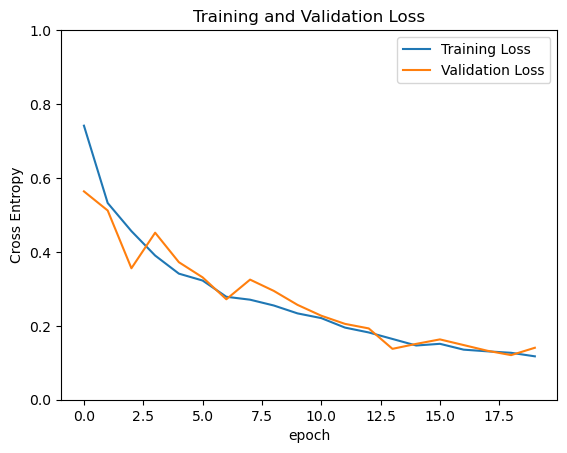

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
# plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate your model

The last thing we need to do is check if the model is overfitting or if it actually learned the problem that fast! Does you model still perform well on the test set? Lets find out!

In [54]:
loss, accuracy = model.evaluate(val_dataset)
print('Test accuracy :', accuracy)

2024-11-11 16:06:34.283426: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.472552: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.472846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.537914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.627592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.688697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.776038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.816725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:06:34.820423: W tensorflow/core/lib/png/png_io.cc:89] PNG 

4/5 [=======================>......] - ETA: 0s - loss: 0.1680 - accuracy: 0.9453

2024-11-11 16:06:35.678334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 [==============================] - 2s 19ms/step - loss: 0.1572 - accuracy: 0.9500
Test accuracy : 0.949999988079071


And assuming your model passed the accuracy threshold you are now are all set to use this model to predict if the person is wearing a mask or not. Lets print the results from a bunch of the images in our test dataset!


2024-11-11 16:07:35.646216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:35.851704: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:35.893166: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:35.905229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:36.022296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:36.063073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:36.145320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:36.184134: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:07:36.188260: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0]


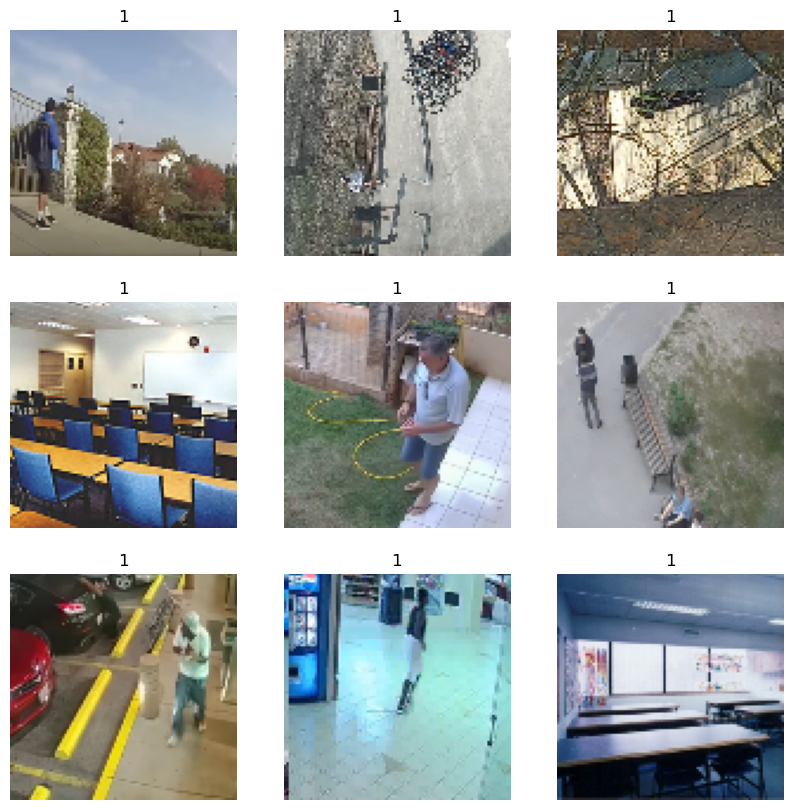

In [56]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch.reshape(-1).astype("uint8"))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using transfer learning for Mask Detection**: In this lab, we learned how we can use transfer learning to detect if a person is wearing mask or not. When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain.



# Model conversion

## Original float model

In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # dynamic range quantization. size reduction but computing is done in fp32
tflite_model = converter.convert()

import pathlib
tflite_model_file = pathlib.Path('model/model-float32.tflite')
tflite_model_file.write_bytes(tflite_model)



INFO:tensorflow:Assets written to: /tmp/tmpjdl1k2hg/assets


INFO:tensorflow:Assets written to: /tmp/tmpjdl1k2hg/assets
W0000 00:00:1731362913.941211 2606196 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731362913.941539 2606196 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-11 16:08:33.941919: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpjdl1k2hg
2024-11-11 16:08:33.970253: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-11 16:08:33.970291: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpjdl1k2hg
I0000 00:00:1731362914.072202 2606196 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-11 16:08:34.101995: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-11 16:08:34.533342: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpjdl1k2hg
2024-11-11 16:08:34.689

550312

## Quantized model

In [58]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  

def representative_data_get():
    for input_value, _ in val_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_get
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path('model/model-int8.tflite')
tflite_model_quant_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmp6pulfcyw/assets


INFO:tensorflow:Assets written to: /tmp/tmp6pulfcyw/assets
/home/heechul/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1731362955.246843 2606196 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731362955.246870 2606196 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-11 16:09:15.247097: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6pulfcyw
2024-11-11 16:09:15.280157: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-11 16:09:15.280187: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp6pulfcyw
2024-11-11 16:09:15.440543: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-11 16:09:15.940822: I tensorflow/cc/saved_model/loader.cc:220] Running 

625104

## Inference

In [59]:
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
img = image_batch[0,:,:,:]
print (img.flatten())

# Write a C source file of the image for debugging purposes (to check if the model output is correct)
with open('src/img.h', 'w') as f:
    f.write('#ifndef IMG_TEST_DATA\n')
    f.write('#define IMG_TEST_DATA\n')
    f.write('const float img_data[] = {')
    for i in range(0, len(img.flatten())):
        f.write(str(img.flatten()[i]))
        if i < len(img.flatten()) - 1:
            f.write(',')    
    f.write('};\n')
    f.write('#endif\n')



2024-11-11 16:09:21.827725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.013864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.017019: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.058562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.139528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.177159: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.253624: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.290506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:09:22.294908: W tensorflow/core/lib/png/png_io.cc:89] PNG 

[120.40886   139.76953   107.89453   ...   1.3750305   1.3607006
   6.041687 ]


In [60]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))
interpreter.invoke()
output = interpreter.get_tensor(output_index)
print(output.flatten())
if output.flatten()[0] < 0.5:
    print("Person")
else:
    print("No person")

[0.984375]
No person


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(96, 96, 3)
[120 139 107]
[120.40886 139.76953 107.89453]


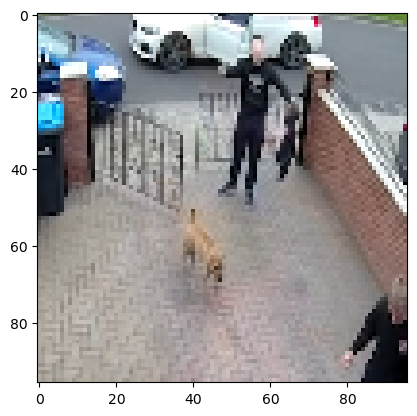

In [61]:
plt.imshow(img.astype("uint8"))
print(img.astype("uint8").shape)
print(img.astype("uint8").flatten()[:3])
print(img.astype("float32").flatten()[:3])

In [63]:
from tqdm import tqdm

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []

    for test_image, test_label in tqdm(val_dataset):
        for i in range(len(test_label)):
            interpreter.set_tensor(input_index, np.expand_dims(test_image[i], axis=0))
            interpreter.invoke()
            prediction_digits.append(interpreter.get_tensor(output_index))
            test_labels.append(test_label[i])
    prediction_digits = np.array(prediction_digits).flatten()
    print(prediction_digits[:10])
    test_labels = np.array(test_labels)
    print(test_labels[:10])
    prediction_digits = np.where(prediction_digits < 0.5, 0, 1)
    print(prediction_digits[:10])

    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Float model accuracy = ', test_accuracy)

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Quantized model accuracy = ', test_accuracy)


  0%|          | 0/5 [00:00<?, ?it/s]2024-11-11 16:10:13.462245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.627008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.631922: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.667341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.733266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.770566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.848022: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.887727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:13.891125: W tenso

[0.934598   0.9990158  0.97576505 0.01448997 0.99012446 0.9915841
 0.9992477  0.9974013  0.14677455 0.9965571 ]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]
[1 1 1 0 1 1 1 1 0 1]
Float model accuracy =  0.521328125


  0%|          | 0/5 [00:00<?, ?it/s]2024-11-11 16:10:15.248064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.470594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.470958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.512959: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.623433: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.673834: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.753407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.789324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 16:10:15.794255: W tenso

[0.98046875 0.17578125 0.8828125  0.890625   0.8671875  0.515625
 0.53515625 0.5        0.08984375 0.9609375 ]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]
[1 0 1 1 1 1 1 1 0 1]
Quantized model accuracy =  0.54125


## Generate model CC file

In [64]:
model_file = 'model-int8'
!xxd -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" | sed "s/model_model_int8_tflite/gmodel/g"> src/model.cc
# !xxd -n gmodel -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" > src/model.cc